In [1]:
import os
#import ipdb

import pandas as pd
import matplotlib as mpl
from matplotlib import lines
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

EXP_NAME = "c11"
headers = ['time','start_transfer', 'latency','gateway','status']
def read_client():
    INPUT_DIR = os.path.join( os.getcwd(), EXP_NAME)
    data = pd.DataFrame()
    dirs = [f for f in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR))]    
    for client in dirs:
        client_data = pd.read_csv(os.path.join(INPUT_DIR, client), sep=',')
        client_data.columns= headers
        client_data = client_data.set_index(pd.DatetimeIndex(client_data.time))
        client_data = client_data.query('status == 200')
        data = pd.concat([data, client_data])
    return data
    
def getECDF(df,column):
    """Helper function that caclulates the ECDF of a dataframe"""
    df = df[column].value_counts()
    ecdf = df.sort_index().cumsum()*1./df.sum()    
    return ecdf

In [2]:
data = read_client()

data.index = data.index.map(lambda x: x.replace(second=0))
data.index = data.index.map(lambda x: x.replace(microsecond=0))

std_data = data['latency'].resample('T').mean().sort_index().rolling('10T').std()
mean_data = data['latency'].resample('T').mean().sort_index().rolling('10T').mean()
general  = pd.merge(std_data, mean_data, how='inner', left_index=True, right_index=True)
#print(len(std_data),len(general))
#print(general.head(10))
#print(general.head())

for name, group in data.groupby(data['gateway']):    
    group_std = group['latency'].sort_index().rolling('10T').std()
    group_mean = group['latency'].sort_index().rolling('10T').mean()
    #print(group_std.head())
    #print(group_mean.())
    
    merged_group = pd.merge(group_std, group_mean, how='inner', left_index=True, right_index=True)
    
    merged_group = pd.merge(merged_group,group['latency'], how ='inner', left_index = True , right_index=True)
    merged_group = pd.merge(general, merged_group, how='inner', left_index = True, right_index=True)
    
    merged_group.columns=['general_std','general_mean','group_std','group_mean','latency']
    
    merged_group.to_csv('std_dev/'+name)
    #print(name, group.query("latency <= "+str(group.latency.quantile(0.99)))['latency'].mean())
    #print(name, group['latency'].mean())
    #group['latency'].plot()

#plt.ylim(0,1)
#plt.show()

In [24]:
import os
#import ipdb

import pandas as pd
import matplotlib as mpl
from matplotlib import lines
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

EXP_NAME = "std_dev"
# Read all standard deviation files of each gateway node and count what category nodes are at each time period
def read_std():
    INPUT_DIR = os.path.join( os.getcwd(), EXP_NAME)
    data = pd.DataFrame()
    dirs = [f for f in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR))]    
    for client in dirs:
        client_data = pd.read_csv(os.path.join(INPUT_DIR, client), sep=',')
        client_data = client_data.set_index(pd.DatetimeIndex(client_data.time))
        #client_data = client_data.tail(1000)
        #['general_std','general_mean','group_std','group_mean','latency']
        client_data = client_data.ix['2019-01-24 00:00':'2019-01-25 00:00']
        #client_data['latency'].plot()
        #plt.ylim(0,3)
        #plt.show()
        print(client, len(client_data))
        for index, row in client_data.iterrows():
            if row['general_mean'] is None:
                continue
            if row['latency'] <= row['general_mean']:
                if row['group_std'] <= row['general_std']:
                    client_data.loc[index, 'category'] = 'Good'
                else:
                    client_data.loc[index, 'category'] = 'Inconsistent'
            else:
                if row['group_std'] < row['general_std']:
                    client_data.loc[index, 'category'] = 'Inconsistent'
                else:
                    client_data.loc[index, 'category'] = 'Bad'
        
        data = pd.concat([data, client_data])
    return data
category_data = read_std()

/home/khulan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


10.138.85.130 1441
10.139.40.122 1441
10.139.17.4 1441
10.139.40.85 1441
10.228.193.210 0
proxy.muntanyola.guifi.net 1555


/home/khulan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



proxy.malla.guifi.net 1555
proxy.sbll.guifi.net 1957
10.228.192.210 1441
proxy.cecilia.guifi.net 1549
10.138.25.67 1441
proxy.olost.guifi.net 1951
10.140.93.35 1440
proxy.elpipa.guifi.net 1549
proxy.perafita.guifi.net 1951
10.139.94.98 1549
proxy.smc.guifi.net 838
10.138.120.66 1441
10.138.57.2 1441
10.139.37.194 1441


In [25]:
#category_data.index = category_data.index.map(lambda x: x.replace(second=0))
#category_data.index = category_data.index.map(lambda x: x.replace(microsecond=0))
#category_data = category_data.ix['2019-02-09 00:00':'2019-02-10 00:00']
category_data = category_data.sort_index()
#category_data.to_csv('help.csv')
counted_df = category_data.groupby([category_data.index, category_data['category']]).count()['latency'].unstack()
#print(counted_df)
counted_df.resample('T').mean().to_csv('category_out.csv')

#counted_df.resample('H').mean().plot()
#plt.show()


               Bad         Good  Inconsistent
count  1217.000000  1384.000000   1281.000000
mean      3.394412    11.133671      4.425449
std       1.508932     2.520526      1.661873
min       1.000000     3.000000      1.000000
25%       2.000000    10.000000      3.000000
50%       3.000000    11.000000      4.000000
75%       4.000000    12.000000      6.000000
max       9.000000    18.000000      9.000000


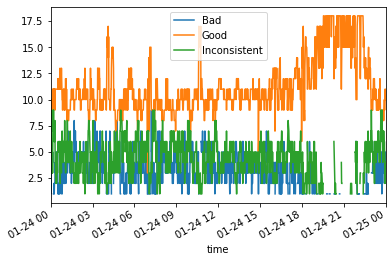

In [30]:
category_df = pd.read_csv('category_out.csv')
category_df = category_df.set_index(pd.DatetimeIndex(category_df.time))

category_df = category_df.query('Good <= 20')
#getECDF(category_df,'Good').plot()
#getECDF(category_df,'Inconsistent').plot()
#getECDF(category_df,'Bad').plot()

print(category_df.describe())
plt.show()

category_df.plot()
plt.show()

In [32]:
import os
#import ipdb

import pandas as pd
import matplotlib as mpl
from matplotlib import lines
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

EXP_NAME = "std_dev"
# Read all standard deviation files of each gateway node and count what category nodes are at each time period
def categorize_by_latency():
    INPUT_DIR = os.path.join( os.getcwd(), EXP_NAME)
    data = pd.DataFrame()
    dirs = [f for f in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR))]    
    for client in dirs:
        client_data = pd.read_csv(os.path.join(INPUT_DIR, client), sep=',')
        client_data = client_data.set_index(pd.DatetimeIndex(client_data.time))
        #client_data = client_data.tail(1000)
        
        client_data = client_data.ix['2019-01-24 00:00':'2019-01-25 00:00']
        print(client)
        for index, row in client_data.iterrows():
            if row['general_mean'] is None:
                continue
            if row['latency'] <= row['general_mean']:
                client_data.loc[index, 'category'] = 'Good'
            else:
                client_data.loc[index, 'category'] = 'Bad'
        
        data = pd.concat([data, client_data])
    return data
latency_category_data = categorize_by_latency()

/home/khulan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


10.138.85.130
10.139.40.122
10.139.17.4
10.139.40.85
10.228.193.210
proxy.muntanyola.guifi.net


/home/khulan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



proxy.malla.guifi.net
proxy.sbll.guifi.net
10.228.192.210
proxy.cecilia.guifi.net
10.138.25.67
proxy.olost.guifi.net
10.140.93.35
proxy.elpipa.guifi.net
proxy.perafita.guifi.net
10.139.94.98
proxy.smc.guifi.net
10.138.120.66
10.138.57.2
10.139.37.194


In [33]:
#latency_category_data.index = latency_category_data.index.map(lambda x: x.replace(second=0))
#latency_category_data.index = latency_category_data.index.map(lambda x: x.replace(microsecond=0))
#latency_category_data = latency_category_data.ix['2019-02-10 00:00':'2019-02-15 00:00']
latency_category_data = latency_category_data.sort_index()
#category_data.to_csv('help.csv')
counted_df = latency_category_data.groupby([latency_category_data.index, latency_category_data['category']]).count()['latency'].unstack()
#print(counted_df)
counted_df.resample('H').mean().to_csv('category_out1.csv')

             Bad       Good
count  22.000000  22.000000
mean    6.295053  13.045455
std     0.740717   2.046013
min     3.607843  11.000000
25%     5.991667  11.754167
50%     6.433333  12.200000
75%     6.720833  13.591667
max     7.116667  19.766667


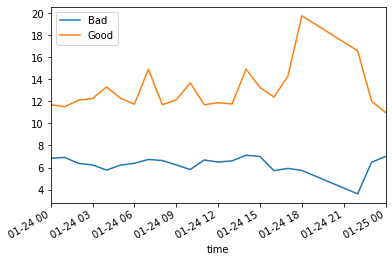

In [36]:
category_latency = pd.read_csv('category_out1.csv')
category_latency = category_latency.set_index(pd.DatetimeIndex(category_latency.time))
category_latency = category_latency.query('Good <= 20')

#category_df = pd.read_csv('category_out.csv')
#category_df = category_df.set_index(pd.DatetimeIndex(category_df.time))

#getECDF(category_df,'Good').plot()
#getECDF(category_df,'Inconsistent').plot()
#getECDF(category_df,'Bad').plot()

print(category_latency.describe())

category_latency.plot()
plt.show()

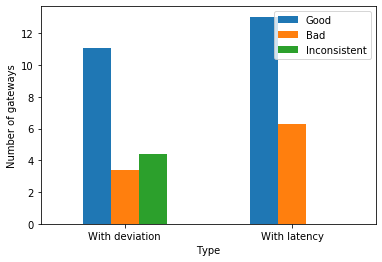

In [44]:
category = pd.read_csv('categorization.csv')
category.plot.bar(x='Type', rot=0)
plt.ylabel('Number of gateways')
plt.show()